In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm 
import time
import os
from PIL import Image
import cv2 

#from model import ContrastiveLoss

import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
#from albumentations.augmentations.transforms import HorizontalFlip,VerticalFlip

%matplotlib inline

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [0]:
class TwinPairsDataset(Dataset):
    def __init__(self, dataroot, df_pairs, df_views, transform, keypoints=False):
        '''
        dataroot: path to folder with items
        df_pairs: pd dataframe containing pairs of ids and a correspodind label:
                    'Same', 'Fraternal', 'Identical', 'UnknownTwinType',
                    'IdenticalMirror', 'Sibling', 'IdenticalTriplet'
        df_views: pd dataframe containing list of available for each id in the dataset                    
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df_pairs = df_pairs
        self.df_views = df_views
        self.transform = transform
        self.keypoints = keypoints
        
    def __getitem__(self, index):
        sample={}
        
        id_1, id_2  = self.df_pairs.iloc[index][['id_1', 'id_2']].values
        id_1 = str(id_1)
        id_2 = str(id_2)
        label = int(self.df_pairs.iloc[index].label=='Same')
        if id_1==id_2:
             view_1, view_2 = np.random.choice(self.df_views.loc[id_1]['filename'], size=2, replace=False) 
        else:
            view_1 = np.random.choice(self.df_views.loc[id_1]['filename'])
            view_2 = np.random.choice(self.df_views.loc[id_2]['filename'])

        path_1 = os.path.join(self.dataroot, id_1, view_1)
        path_2 = os.path.join(self.dataroot, id_2, view_2)
        
        img_1 = Image.open(path_1)
        img_2 = Image.open(path_2)
        if self.keypoints:
            df_keypoints=pd.read_csv(self.dataroot+'/df/aligned_landmarks.csv')
            df_flip_keypoints=pd.read_csv(self.dataroot+'/df/aligned_FLIP_landmarks.csv')
            
            if id_1==id_2:
                keypoints_1 = df_keypoints[view_1].values
                keypoints_1=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_1])
                if self.transform['same']==self.transform['twin']:
                  keypoints_2 = df_keypoints[view_2].values
                  keypoints_2=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_2])
                else:
                  keypoints_2 = df_flip_keypoints[view_2].values
                  keypoints_2=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_2])
                
            else:
                keypoints_1 = df_keypoints[view_1].values
                keypoints_2 = df_keypoints[view_2].values
                keypoints_1=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_1])
                keypoints_2=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_2])
            sample['keypoints_1'] = keypoints_1
            sample['keypoints_2'] = keypoints_2
        
        if label==1:
            img_1 = self.transform['twin'](img_1)
            img_2 = self.transform['same'](img_2)
        else:
            img_1 = self.transform['twin'](img_1)
            img_2 = self.transform['twin'](img_2)
            
        sample['img_1']=img_1
        sample['img_2']=img_2
        sample['label']=label
        
        return sample
    
    def __len__(self):
        return self.df_pairs.shape[0]

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_transform ={
    'same': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.RandomHorizontalFlip(p=1),
            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'twin': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                }
views = pd.read_csv('/content/drive/My Drive/DL_project/twins_aligned_cropped_resized/df/views.csv', index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv('/content/drive/My Drive/DL_project/twins_aligned_cropped_resized/df/pairs_train_fedor.csv')

direct='/content/drive/My Drive/DL_project/twins_aligned_cropped_resized/'
dataset = TwinPairsDataset(direct, pairs, views,transform=data_transform, keypoints=True)
dataloader = DataLoader(dataset, batch_size=10,shuffle=True)

## Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


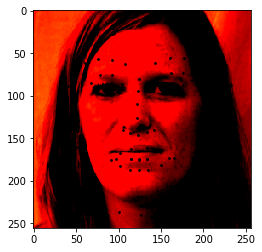

In [7]:
idx = 119

sample = dataset[idx]
std=sample['img_1'].numpy().std()
mean=sample['img_1'].numpy().mean()
plt.imshow(sample['img_1'].numpy().transpose(1,2,0)*std+mean)
kp = sample['keypoints_1']
plt.scatter(kp[:,0], kp[:,1], s=3,color='black')
plt.show()

In [0]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
import torch.nn.functional as F
import torch
from collections import namedtuple
import math
import pdb

##################################  Original Arcface Model #############################################################

class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class SEModule(Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc1 = Conv2d(
            channels, channels // reduction, kernel_size=1, padding=0 ,bias=False)
        self.relu = ReLU(inplace=True)
        self.fc2 = Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0 ,bias=False)
        self.sigmoid = Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class bottleneck_IR(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride ,bias=False), BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1 ,bias=False), PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1 ,bias=False), BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)
        return res + shortcut

class bottleneck_IR_SE(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR_SE, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride ,bias=False), 
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3,3), (1,1),1 ,bias=False),
            PReLU(depth),
            Conv2d(depth, depth, (3,3), stride, 1 ,bias=False),
            BatchNorm2d(depth),
            SEModule(depth,16)
            )
    def forward(self,x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)
        return res + shortcut

class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
    '''A named tuple describing a ResNet block.'''
    
def get_block(in_channel, depth, num_units, stride = 2):
  return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units-1)]

def get_blocks(num_layers):
    if num_layers == 50:
        blocks = [
            get_block(in_channel=64, depth=64, num_units = 3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=14),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 100:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=13),
            get_block(in_channel=128, depth=256, num_units=30),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 152:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=8),
            get_block(in_channel=128, depth=256, num_units=36),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    return blocks

class Backbone(Module):
    def __init__(self, num_layers, drop_ratio, mode='ir'):
        super(Backbone, self).__init__()
        assert num_layers in [50, 100, 152], 'num_layers should be 50,100, or 152'
        assert mode in ['ir', 'ir_se'], 'mode should be ir or ir_se'
        blocks = get_blocks(num_layers)
        if mode == 'ir':
            unit_module = bottleneck_IR
        elif mode == 'ir_se':
            unit_module = bottleneck_IR_SE
        self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1 ,bias=False), 
                                      BatchNorm2d(64), 
                                      PReLU(64))
        self.output_layer = Sequential(BatchNorm2d(512), 
                                       Dropout(drop_ratio),
                                       Flatten(),
                                       Linear(512 * 7 * 7, 512),
                                       BatchNorm1d(512))
        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(
                    unit_module(bottleneck.in_channel,
                                bottleneck.depth,
                                bottleneck.stride))
        self.body = Sequential(*modules)
    
    def forward(self,x):
        x = self.input_layer(x)
        x = self.body(x)
        x = self.output_layer(x)
        return l2_norm(x)

##################################  MobileFaceNet #############################################################
    
class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output

class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)

class MobileFaceNet(Module):
    def __init__(self, embedding_size):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
        self.conv_3 = Residual(64, num_block=4, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        self.conv_4 = Residual(128, num_block=6, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512)
        self.conv_5 = Residual(128, num_block=2, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(7,7), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)
        
        out = self.conv_34(out)

        out = self.conv_4(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.conv_6_dw(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)
        return l2_norm(out)

##################################  Arcface head #############################################################

class Arcface(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599    
    def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
        self.threshold = math.cos(math.pi - m)
    def forward(self, embbedings, label):
        # weights norm
        nB = len(embbedings)
        kernel_norm = l2_norm(self.kernel,axis=0)
        # cos(theta+m)
        cos_theta = torch.mm(embbedings,kernel_norm)
#         output = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_theta - self.threshold
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output

##################################  Cosface head #############################################################    
    
class Am_softmax(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599    
    def __init__(self,embedding_size=512,classnum=51332):
        super(Am_softmax, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = 0.35 # additive margin recommended by the paper
        self.s = 30. # see normface https://arxiv.org/abs/1704.06369
    def forward(self,embbedings,label):
        kernel_norm = l2_norm(self.kernel,axis=0)
        cos_theta = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        phi = cos_theta - self.m
        label = label.view(-1,1) #size=(B,1)
        index = cos_theta.data * 0.0 #size=(B,Classnum)
        index.scatter_(1,label.data.view(-1,1),1)
        index = index.byte()
        output = cos_theta * 1.0
        output[index] = phi[index] #only change the correct predicted output
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output



In [0]:
#from model import MobileFaceNet

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"/content/drive/My Drive/DL_project/model_mobilefacenet.pth")

checkpoint = torch.load(PATH,map_location=device)

model.load_state_dict(checkpoint)
optimizer = optim.SGD(model.parameters(),lr=0.1)

#### Load pretrained model

In [0]:
class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        output = self.features(x)
        return output

#define model and fix hidden features size
model_flatten = ModelBottom(model)
T=next(iter(dataloader))
outputs = model_flatten(T['img_2'])
hid_size=outputs.data.shape[1]

#define n_classes
classes=os.listdir(direct)
n_classes=len(classes)

#define classifier
model_flatten_classifier = nn.Sequential(
                      nn.Linear(hid_size, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

# concatenate conv MobileFaceNet and classifier
class FinModel(nn.Module):
    def __init__(self,flatten_model,classifier_model):
        super(FinModel, self).__init__()
        self.to_flat_model=flatten_model
        self.classifier_model=classifier_model
    def forward(self,x):
        outputs=self.to_flat_model(x)
        outputs=self.classifier_model(outputs)
        return outputs
for param in model_flatten.parameters():
    param.requires_grad = False

In [0]:
class myModel(nn.Module):
        def __init__(self):
            super(myModel,self).__init__()
            self.model_start = model_flatten
            self.fc_layers = nn.Sequential(
                      nn.Linear(hid_size, 500),
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True), 
                      nn.Linear(500,5))
   	    
        def forward(self,x):
            out1 = self.model_start(x)
            return self.fc_layers(out1)

In [0]:
model_final = myModel()

In [0]:
def train(output_path, model, dataloader, optimizer,criterion, device, n_epochs=100):
    model.to(device)
    loss_hist=[]
    for epoch in range(n_epochs):
        loss_epoch = 0
        for i,batch_item in enumerate(dataloader):
            result_img_a=model(batch_item['img_1'].cuda(device))
            result_img_b=model(batch_item['img_2'].cuda(device))
            label=batch_item['label']
            loss_batch=0
            loss=0
            optimizer.zero_grad()
            
            for j in range(result_img_a.shape[0]):
                loss += criterion(result_img_a[j][None],result_img_b[j][None],label[j])        
            loss_batch+=loss.detach().cpu().item()
            if i % 100 == 0: print("Loss_batch={}".format(loss_batch))
            loss.backward(retain_graph=True)
            optimizer.step()
            loss_epoch+=loss_batch
           
           
        loss_hist.append(loss_epoch)
        torch.save(model.state_dict(),str(output_path) + '/{}_epoch.pt'.format(epoch+1))
        plt.plot(loss_hist) 
        plt.title('loss')
        plt.legend()
        plt.show()    
    model.eval()

In [13]:
model_final = myModel()
optimizer = optim.Adam(model_final.parameters(),lr = 0.0005)
criterion=ContrastiveLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train("/content/drive/My Drive/DL_project/mobile_chkpts",model_final,dataloader,optimizer,criterion,device,n_epochs=10)

NameError: ignored

In [14]:
PATH = str("/content/drive/My Drive/DL_project/mobile_chkpts/") + '/{}_epoch.pt'.format(4)
checkpoint = torch.load(PATH,map_location=device)

model_final.load_state_dict(checkpoint)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [15]:
model_final.cuda()
model_final.eval()

myModel(
  (model_start): ModelBottom(
    (features): Sequential(
      (0): Conv_block(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
      )
      (1): Conv_block(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
      )
      (2): Depth_Wise(
        (conv): Conv_block(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (prelu): PReLU(num_parameters=128)
        )
        (conv_dw): Conv_block(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), 

### validation

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_transform ={
    'same': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'twin': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                }
views = pd.read_csv('/content/drive/My Drive/DL_project/twins_aligned_cropped_resized/df/views.csv', index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs_test = pd.read_csv('/content/drive/My Drive/DL_project/twins_aligned_cropped_resized/df/pairs_test_fedor.csv')
pairs_train = pd.read_csv('/content/drive/My Drive/DL_project/twins_aligned_cropped_resized/df/pairs_train_fedor.csv')
direct='/content/drive/My Drive/DL_project/twins_aligned_cropped_resized/'
dataset_test = TwinPairsDataset(direct, pairs_test, views,transform=data_transform, keypoints=True)
dataloader_test = DataLoader(dataset_test, batch_size=5,shuffle=True)
dataset_train = TwinPairsDataset(direct, pairs_train, views,transform=data_transform, keypoints=True)
dataloader_train = DataLoader(dataset_train, batch_size=5,shuffle=True)

In [0]:
T=next(iter(dataloader_train))

In [0]:

outputs1 = model_final(T['img_1'].cuda())
outputs2 = model_final(T['img_2'].cuda())
target_train = T['label']
X_train = torch.cat((outputs1,outputs2),dim=1)

In [0]:
X_newkp1 = T['keypoints_1'].float().view(-1,68*2).cuda()
X_newkp2 = T['keypoints_2'].float().view(-1,68*2).cuda()
X_concat_all_kp = torch.cat((X_newkp1, X_newkp2), dim=1)
X_train_all = torch.cat((X_train,X_concat_all_kp), dim=1)

In [20]:
for i,batch_item in tqdm(enumerate(dataloader_train)):
            result_img_a = model_final(batch_item['img_1'].cuda())
            result_img_b = model_final(batch_item['img_2'].cuda())
            X_train = torch.cat((X_train,torch.cat((result_img_a,result_img_b),dim=1)), dim=0)
            newkp1 = batch_item['keypoints_1'].float().view(-1,68*2).cuda()
            newkp2 = batch_item['keypoints_2'].float().view(-1,68*2).cuda()
            X_concat_all = torch.cat((torch.cat((result_img_a,result_img_b),dim=1),torch.cat((newkp1, newkp2), dim=1)), dim=1)
            X_train_all = torch.cat((X_train_all, X_concat_all), dim=0)
            target_train = torch.cat((target_train,batch_item['label']),dim=0)

In [21]:
X_train_all.shape

torch.Size([578, 282])

In [0]:
T=next(iter(dataloader_test))

In [23]:

outputs1_test = model_final(T['img_1'].cuda())
outputs2_test = model_final(T['img_2'].cuda())
target_test = T['label']
X_test= torch.cat((outputs1_test,outputs2_test),dim=1)
X_newkp1_test = T['keypoints_1'].float().view(-1,68*2).cuda()
X_newkp2_test = T['keypoints_2'].float().view(-1,68*2).cuda()
X_concat_all_kp_test= torch.cat((X_newkp1, X_newkp2), dim=1)
X_test_all = torch.cat((X_test,X_concat_all_kp), dim=1)
for i,batch_item in tqdm(enumerate(dataloader_test)):
            result_img_a = model_final(batch_item['img_1'].cuda())
            result_img_b = model_final(batch_item['img_2'].cuda())
            X_test = torch.cat((X_test,torch.cat((result_img_a,result_img_b),dim=1)), dim=0)
            newkp1 = batch_item['keypoints_1'].float().view(-1,68*2).cuda()
            newkp2 = batch_item['keypoints_2'].float().view(-1,68*2).cuda()
            X_concat_all = torch.cat((torch.cat((result_img_a,result_img_b),dim=1),torch.cat((newkp1, newkp2), dim=1)), dim=1)
            X_test_all = torch.cat((X_test_all, X_concat_all), dim=0)
            target_test = torch.cat((target_test,batch_item['label']),dim=0)

In [24]:
target_test.shape

torch.Size([282])

### Without any additional features

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,roc_auc_score,recall_score,precision_score

In [0]:
target_train_numpy = target_train.detach().cpu().numpy()
X_train_numpy = X_train_all.detach().cpu().numpy()
target_test_numpy = target_test.detach().cpu().numpy()
X_test_numpy = X_test_all.detach().cpu().numpy()

In [27]:
svc = SVC(kernel='linear', C=10, probability=True)
svc.fit(X_train_numpy, target_train_numpy)
preds = svc.predict_proba(X_test_numpy)
roc_auc_score(target_test_numpy, preds[:,1])

0.9691414141414141

In [0]:
y_pred=svc.predict(X_test_numpy)

In [29]:
preds_train = svc.predict_proba(X_train_numpy)
roc_auc_score(target_train_numpy, preds_train[:,1])

1.0

In [30]:
len(y_pred)

282

In [0]:
label = target_test_numpy

In [32]:
print(accuracy_score(y_pred,label))
print(roc_auc_score(y_pred,label))
print(recall_score(y_pred,label))
print(precision_score(y_pred,label))

0.9680851063829787
0.9681765330367524
0.9668874172185431
0.9733333333333334
